<a href="https://colab.research.google.com/github/narendrapatel6321-dotcom/NLP-Assignments/blob/main/25N0242_NLP_Assignment_3_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import gdown # For downloading files from Google Drive
from bs4 import BeautifulSoup # For parsing HTML
from collections import Counter # For counting word frequencies
from sklearn.model_selection import train_test_split # For splitting data
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence # For padding sequences
from torch.utils.data import TensorDataset,DataLoader # For creating data loaders
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix # For evaluation metrics
import seaborn as sns # For plotting confusion matrix

#Importing Dataset

In [ ]:
# Define the Google Drive file ID for the dataset
file_id = "1A8mqzrqeTUj8Rbh52w0mru_GxONjHVJv"
# Construct the download URL
url = f"https://drive.google.com/uc?id={file_id}"

# Define the output filename
output = "data.csv"
# Download the file from Google Drive
gdown.download(url, output, quiet=True)

# Read the downloaded CSV file into a pandas DataFrame
df = pd.read_csv(output)
# Display the first 5 rows of the DataFrame to inspect the data
print(df.head(5))

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


#Cleaning And Label Encoding

In [ ]:
# Function to clean raw text:
def clean_review(text):
  # Define regex patterns for URLs and punctuation
  url_pattern = r'https?://\S+|www\.\S+'
  punctuation_pattern = r"[^\w\s']"

  # Lowercase all text
  text = text.lower()

  # Remove HTML tags using BeautifulSoup
  text = BeautifulSoup(text, "html.parser").get_text()

  # Remove URLs using regex
  text = re.sub(url_pattern,'',text)

  # Remove punctuation
  text = re.sub(punctuation_pattern,'',text)

  # Normalize whitespace and strip leading/trailing spaces
  text = re.sub(r'\s+', ' ', text)
  text = text.strip()

  return text

In [ ]:
# Convert 'positive' sentiment to 1 and others (negative) to 0
df["sentiment"] = df["sentiment"].apply(lambda x : 1 if x == "positive" else 0)
# Apply the cleaning function to the 'review' column and create a new 'cleaned_review' column
df["cleaned_review"] = df["review"].apply(clean_review)

In [ ]:
# Display the original 'review' and the encoded 'sentiment' columns for verification
print(df[["review","sentiment"]].head())

                                              review  sentiment
0  One of the other reviewers has mentioned that ...          1
1  A wonderful little production. <br /><br />The...          1
2  I thought this was a wonderful way to spend ti...          1
3  Basically there's a family where a little boy ...          0
4  Petter Mattei's "Love in the Time of Money" is...          1


In [ ]:
# Display the original 'review' and the 'cleaned_review' columns to see the effect of cleaning
print(df[["review","cleaned_review"]].head())

                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                      cleaned_review  
0  one of the other reviewers has mentioned that ...  
1  a wonderful little production the filming tech...  
2  i thought this was a wonderful way to spend ti...  
3  basically there's a family where a little boy ...  
4  petter mattei's love in the time of money is a...  


#Train, Test, Val Split

In [ ]:
# Split the data into training, temporary (for validation and testing) sets
train_texts, temp_texts, y_train, y_temp = train_test_split(df['cleaned_review'],
                                                            df['sentiment'],
                                                            test_size=0.3, # 30% for temporary set
                                                            random_state=42) # For reproducibility

# Split the temporary set into validation and test sets
val_texts, test_texts, y_val, y_test = train_test_split(temp_texts, y_temp,
                                                        test_size=0.5, # 50% of temp (15% of total) for test
                                                        random_state=42) # For reproducibility


# Print the size of each set to verify the split
print(f"Train: {len(train_texts)} | Val: {len(val_texts)} | Test: {len(test_texts)}")

Train: 35000 | Val: 7500 | Test: 7500


#Building Vocabulary, Tokenization And Padding

In [ ]:
# Build vocabulary (with <OOV> at end)
def build_vocab(texts, max_size=19999, min_freq=1):
    """
    Builds a vocabulary from a list of text documents.

    Args:
        texts (list): A list of text strings.
        max_size (int): The maximum size of the vocabulary (excluding padding).
        min_freq (int): The minimum frequency a word must have to be included.

    Returns:
        dict: A dictionary mapping words to their integer indices.
    """
    counter = Counter()
    for text in texts:
        counter.update(text.split())

    # keep most frequent words, reserving one spot for <PAD>
    most_common = counter.most_common(max_size - 1)

    # Create the vocabulary dictionary, starting with <PAD>
    vocab = {"<PAD>": 0}
    vocab.update({word: idx + 1 for idx, (word, _) in enumerate(most_common)})

    # Add <OOV> at the end for out-of-vocabulary words
    vocab["<OOV>"] = len(vocab)
    return vocab

# Convert text to integer sequence
def text_to_sequence(text, vocab):
    """
    Converts a text string into a sequence of integer IDs based on the vocabulary.

    Args:
        text (str): The input text string.
        vocab (dict): The vocabulary dictionary mapping words to IDs.

    Returns:
        list: A list of integer IDs representing the text.
    """
    # Get the ID for out-of-vocabulary words
    oov_id = vocab["<OOV>"]
    # Split text into words and get their IDs from the vocabulary, defaulting to <OOV> ID
    return [vocab.get(word, oov_id) for word in text.split()]

# Pad sequences
def pad_sequences_torch(sequences, maxlen=200):
    """
    Pads sequences to a fixed length using PyTorch's pad_sequence.

    Args:
        sequences (list): A list of sequences (lists of integers).
        maxlen (int): The maximum length to pad/truncate sequences to.

    Returns:
        torch.Tensor: A padded tensor of sequences.
    """
    # Truncate sequences to maxlen and convert to torch tensors
    seqs = [torch.tensor(seq[:maxlen]) for seq in sequences]
    # Pad sequences to the same length (the length of the longest sequence in the batch if batch_first=True,
    # or maxlen if it's explicitly set and the sequences were truncated).
    # padding_value=0 corresponds to the <PAD> token ID.
    return pad_sequence(seqs, batch_first=True, padding_value=0)

In [ ]:
# Build the vocabulary using the training texts to prevent data leakage
vocab = build_vocab(train_texts)
# Get the size of the vocabulary
vocab_size = len(vocab)
print(f"Vocab size: {vocab_size}")

# Convert text data to integer sequences using the built vocabulary
train_seq = [text_to_sequence(t, vocab) for t in train_texts]
val_seq   = [text_to_sequence(t, vocab) for t in val_texts]
test_seq  = [text_to_sequence(t, vocab) for t in test_texts]

Vocab size: 20000


In [ ]:
# Define the maximum sequence length for padding and truncation
maxlen = 200
# Pad the sequences to the defined maximum length using PyTorch's pad_sequence
train_pad = pad_sequences_torch(train_seq, maxlen=maxlen)
val_pad   = pad_sequences_torch(val_seq,   maxlen=maxlen)
test_pad  = pad_sequences_torch(test_seq,  maxlen=maxlen)

#Converting to Torch tensors

In [ ]:
# Convert pandas Series to torch tensors
X_train = train_pad
y_train = torch.tensor(y_train.values, dtype=torch.float32)

X_val = val_pad
y_val = torch.tensor(y_val.values, dtype=torch.float32)

X_test = test_pad
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Setting Device to Cuda

In [ ]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device available for running: ")
print(device)

Device available for running: 
cuda


# Preparing Data for Model Training

In [ ]:
# Create TensorDatasets for training, testing, and validation
train_data = TensorDataset(X_train,y_train)
test_data = TensorDataset(X_test,y_test)
val_data = TensorDataset(X_val,y_val)

In [ ]:
# Create DataLoaders for training, validation, and testing
# DataLoaders help in iterating over the dataset in batches
train_loader = DataLoader(train_data, batch_size=32, shuffle=True) # Shuffle training data for better training
val_loader = DataLoader(val_data, batch_size=32, shuffle=False) # No need to shuffle validation data
test_loader = DataLoader(test_data,batch_size=32,shuffle=False) # No need to shuffle test data

# Setting Early Stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        """
        Stops training if validation loss doesn't improve after 'patience' epochs.
        Args:
            patience (int): how many epochs to wait after last improvement
            min_delta (float): minimum change in validation loss to qualify as improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0
        self.should_stop = False

    def __call__(self, val_loss):
        """
        Call method to check if training should be stopped.
        Args:
            val_loss (float): Current validation loss.
        """
        if val_loss < self.best_loss - self.min_delta:
            # If validation loss improves, reset counter and update best loss
            self.best_loss = val_loss
            self.counter = 0
        else:
            # If validation loss does not improve, increment counter
            self.counter += 1
            if self.counter >= self.patience:
                # If counter exceeds patience, set should_stop to True
                self.should_stop = True

#
#
#
#
#

# Defining Various Functions to remove redundancy

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, early_stopper=None):
    """
    Trains a PyTorch model and evaluates it on a validation set.

    Args:
        model (torch.nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for the training data.
        val_loader (DataLoader): DataLoader for the validation data.
        criterion (torch.nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer.
        num_epochs (int): Number of training epochs.
        device (torch.device): Device to train on (cuda or cpu).
        early_stopper (EarlyStopping, optional): EarlyStopping instance. Defaults to None.

    Returns:
        tuple: Lists of training and validation losses per epoch.
    """

    train_loss_list = []
    val_loss_list = []

    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train()
        epoch_loss = 0

        # Iterate over the training data
        for batch_X, batch_y in train_loader:
            # Move data to the specified device (GPU or CPU)
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device).view(-1, 1)

            # Forward pass: compute predicted outputs
            predictions = model(batch_X)
            # Compute loss
            loss = criterion(predictions, batch_y)
            # Accumulate the training loss
            epoch_loss += loss.item()

            # Backward pass and optimize
            optimizer.zero_grad() # Clear previous gradients
            loss.backward() # Compute gradients
            # Clip gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step() # Update model parameters

        # Validation phase
        val_loss = 0
        correct = 0
        total = 0
        # Set the model to evaluation mode
        model.eval()
        # Disable gradient calculation during validation
        with torch.no_grad():
            # Iterate over the validation data
            for eval_X, eval_Y in val_loader:
                # Move data to the specified device
                eval_X = eval_X.to(device)
                eval_Y = eval_Y.to(device).view(-1, 1)

                # Forward pass: compute predicted outputs
                preds = model(eval_X)
                # Compute validation loss
                loss = criterion(preds, eval_Y)
                # Accumulate the validation loss
                val_loss += loss.item()

                # Calculate accuracy
                predicted = (preds > 0.5).float()
                correct += (predicted == eval_Y).sum().item()
                total += eval_Y.size(0)

        # Calculate average losses and accuracy
        val_loss /= len(val_loader)
        val_acc = correct / total
        avg_loss = epoch_loss / len(train_loader)

        # Store losses for plotting
        train_loss_list.append(avg_loss)
        val_loss_list.append(val_loss)

        # Print epoch statistics
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Check for early stopping
        if early_stopper:
            early_stopper(val_loss)
            if early_stopper.should_stop:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Return the lists of training and validation losses
    return train_loss_list, val_loss_list

In [ ]:
def test_model(model, test_loader, device):
    """
    Evaluates a PyTorch model on a test set.

    Args:
        model (torch.nn.Module): The model to test.
        test_loader (DataLoader): DataLoader for the test data.
        device (torch.device): Device to test on (cuda or cpu).

    Returns:
        tuple: Lists of true labels and predicted labels.
    """
    all_preds = []
    all_labels = []

    # Set the model to evaluation mode
    model.eval()
    # Disable gradient calculation during testing
    with torch.no_grad():
        # Iterate over the test data
        for batch_X, batch_y in test_loader:
            # Move data to the specified device
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            # Forward pass: compute predicted outputs
            outputs = model(batch_X)

            # Assuming binary classification with sigmoid output, get predictions
            preds = (outputs > 0.5).int()

            # Store results (move to CPU and convert to numpy arrays)
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(batch_y.cpu().numpy().flatten())

    return all_labels, all_preds

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

def get_scores(y_true,y_pred):
  """
  Calculates evaluation metrics (accuracy, precision, recall, F1-score).

  Args:
      y_true (list or array): True labels.
      y_pred (list or array): Predicted labels.

  Returns:
      tuple: Accuracy, Precision, Recall, and F1-score.
  """
  accuracy = accuracy_score(y_true, y_pred)
  # Use average="binary" for binary classification metrics
  precision = precision_score(y_true,y_pred,average="binary")
  recall = recall_score(y_true,y_pred,average="binary")
  f1 = f1_score(y_true,y_pred,average="binary")

  return accuracy,precision,recall,f1

In [ ]:
def print_scores(model_name,y_true,y_pred):
  """
  Calculates and prints evaluation scores for a model.

  Args:
      model_name (str): Name of the model.
      y_true (list or array): True labels.
      y_pred (list or array): Predicted labels.
  """

  # Get the scores using the get_scores function
  accuracy,precision,recall,f1 = get_scores(y_true,y_pred)

  # Print the scores
  print(f"Scores for {model_name} :- ")
  print(f"accuracy score : {accuracy:.4f}")
  print(f"precision score : {precision:.4f}")
  print(f"recall score : {recall:.4f}")
  print(f"f1 score : {f1:.4f}")

In [ ]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Calculates and plots the confusion matrix.

    Args:
        y_true (list or array): True labels.
        y_pred (list or array): Predicted labels.
        model_name (str): Name of the model for the title.
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

In [ ]:
def plot_losses(train_losses, val_losses, model_name):
    """
    Plots training and validation losses over epochs.

    Args:
        train_losses (list): List of training losses per epoch.
        val_losses (list): List of validation losses per epoch.
        model_name (str): Name of the model for the plot title.
    """
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#Making RNN Model

In [ ]:
# Using PyTorch's built-in RNN
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, num_layers=1,dropout_rate=0):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Embedding layer to convert word indices to dense vectors
        self.embedding = nn.Embedding(vocab_size,embedding_dim,padding_idx=0)
        # Built-in RNN layer
        self.rnn = nn.RNN(input_size=embedding_dim,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True, # Input and output tensors are provided as (batch, seq, feature)
                          dropout=dropout_rate if num_layers > 1 else 0) # Dropout applied between RNN layers

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(dropout_rate)

        # Output layer (fully connected)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Forward pass of the RNN model.

        x: (batch_size, seq_length) — contains word indices
        """
        # Apply embedding to input
        x = self.embedding(x)
        # Pass through RNN layer
        # rnn_out: output features from the last layer of the RNN, for each time step
        # h_n: hidden state for the last time step of each layer
        rnn_out, h_n = self.rnn(x)

        # Take the output from the last time step
        last_output = rnn_out[:, -1, :]  # Shape: (batch_size, hidden_size)

        # Apply dropout
        last_output = self.dropout(last_output)
        # Pass through output layer with sigmoid activation for binary classification
        output = torch.sigmoid(self.fc(last_output))

        return output

# Training RNN Model

In [ ]:
# Instantiate the RNN model with specified parameters
rnn_model = RNNModel(vocab_size=vocab_size,
                 embedding_dim=100,
                 hidden_size=128,
                 output_size=1,dropout_rate=0.5).to(device) # Move model to the selected device (GPU or CPU)

# Define the loss function (Binary Cross Entropy for binary classification)
rnn_criterion = nn.BCELoss()
# Define the optimizer (Adam optimizer with a learning rate of 1e-3)
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-3)


In [ ]:
# Define the number of training epochs
num_epochs = 8

# Train the RNN model using the defined function and parameters
rnn_train_loss_list,rnn_val_loss_list = train_model(rnn_model,train_loader,
                                                    val_loader,rnn_criterion,
                                                    rnn_optimizer,num_epochs,device,
                                                    )

Epoch [1/8], Loss: 0.6969, Val Loss: 0.6942, Val Acc: 0.4973
Epoch [2/8], Loss: 0.6965, Val Loss: 0.6936, Val Acc: 0.4936
Epoch [3/8], Loss: 0.6974, Val Loss: 0.6927, Val Acc: 0.5055
Epoch [4/8], Loss: 0.6943, Val Loss: 0.7029, Val Acc: 0.4999
Epoch [5/8], Loss: 0.6729, Val Loss: 0.6595, Val Acc: 0.6309
Epoch [6/8], Loss: 0.6445, Val Loss: 0.6379, Val Acc: 0.6625
Epoch [7/8], Loss: 0.6159, Val Loss: 0.6563, Val Acc: 0.6356
Epoch [8/8], Loss: 0.5903, Val Loss: 0.6281, Val Acc: 0.6736


#Evaluation of RNN Model

In [ ]:
# Evaluate the RNN model on the test set
rnn_all_labels,rnn_all_preds = test_model(rnn_model,test_loader,device)

In [ ]:
# Print the evaluation scores for the RNN model
print_scores("RNN",rnn_all_labels,rnn_all_preds)

Scores for RNN :- 
accuracy score : 0.6793
precision score : 0.6841
recall score : 0.6752
f1 score : 0.6796


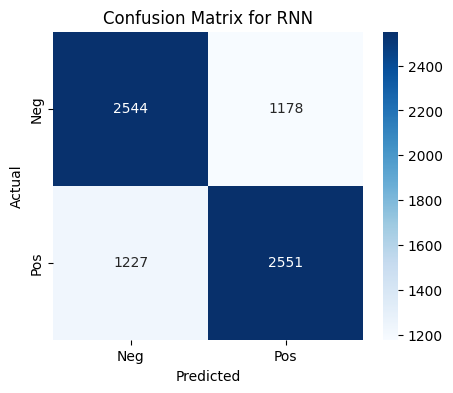

In [ ]:
# Plot the confusion matrix for the RNN model
plot_confusion_matrix(rnn_all_labels,rnn_all_preds,"RNN")

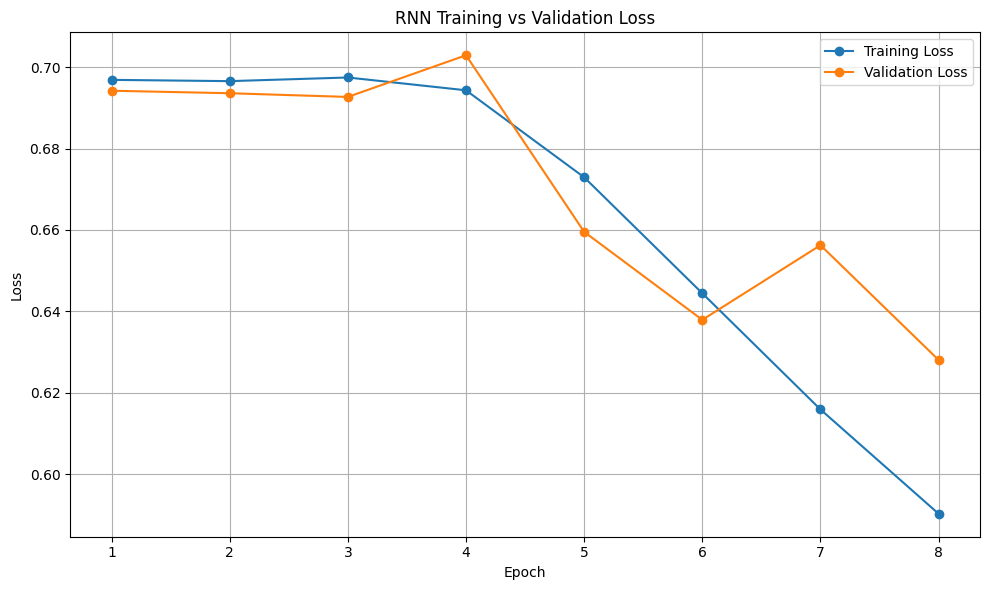

In [ ]:
plot_losses(rnn_train_loss_list,rnn_val_loss_list,"RNN")

## RNN Model Report

### Preprocessing
- **Text Cleaning:** Lowercased, removed HTML tags, URLs, punctuation, and extra spaces.
- **Tokenization:** Used Keras Tokenizer with a vocabulary size of 20,000, including an unknown token.
- **Padding:** Sequences padded/truncated to a maximum length of 200.
- **Data Split:** 70% for training, 15% for validation, and 15% for testing.

### Model Architecture (PyTorch)
- **Embedding Layer:** Maps words to 100-dimensional vectors.
- **RNN Layer:** Single layer with a hidden size of 128.
- **Dropout Layer:** Applied after the RNN output with a rate of 0.5 to prevent overfitting.
- **Output Layer:** Fully connected layer followed by a Sigmoid activation for binary classification.

### Training
- **Loss Function:** Binary Cross Entropy (BCELoss).
- **Optimizer:** Adam with a learning rate of 1e-3.
- **Epochs:** Trained for 8 epochs with a batch size of 32.

### Results
| Metric    | Value |
|-----------|-------|
| Accuracy  | ~0.67 |
| Precision | ~0.68 |
| Recall    | ~0.67 |
| F1-score  | ~0.67 |

### Insights
- The RNN model captured basic sentiment patterns but struggled with longer dependencies in the text.
- Model accuracy showed gradual improvement over epochs, particularly after the initial ~6 epochs.
- Potential improvements could involve using more advanced architectures like LSTM or GRU, leveraging pre-trained word embeddings, or implementing early stopping more effectively.
- Loss curves suggest stable training without significant overfitting.

#Making LSTM Model

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size,
                 num_layers=1, dropout_rate=0, bidirectional=False):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0,
            bidirectional=bidirectional # Enable bidirectional LSTM
        )

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)
        # Output layer, size depends on whether LSTM is bidirectional
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)

    def forward(self, x):
        # Apply embedding
        x = self.embedding(x)
        # Pass through LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        if self.bidirectional:
            # Concatenate last forward & backward hidden states from the last layer
            # h_n shape: (num_layers * num_directions, batch_size, hidden_size)
            # Reshape h_n to (num_layers, num_directions, batch_size, hidden_size)
            h_n = h_n.view(self.num_layers, 2, x.size(0), self.hidden_size)
            # Take the last layer's forward (index 0) and backward (index 1) hidden states
            last_output = torch.cat((h_n[-1, 0], h_n[-1, 1]), dim=1)
        else:
            # Use the output from the last time step of the last layer
            last_output = lstm_out[:, -1, :] # Shape: (batch_size, hidden_size)


        # Apply dropout
        last_output = self.dropout(last_output)
        # Pass through output layer with sigmoid activation
        output = torch.sigmoid(self.fc(last_output))
        return output

#Training LSTM Model

In [ ]:
# Instantiate the LSTM model with specified parameters
lstm_model = LSTMModel(vocab_size=vocab_size,
                 embedding_dim=100,
                 hidden_size=128,
                 output_size=1,dropout_rate=0.5).to(device) # Move model to the selected device (GPU or CPU)

# Define the loss function (Binary Cross Entropy for binary classification)
lstm_criterion = nn.BCELoss()
# Define the optimizer (Adam optimizer with a learning rate of 1e-3)
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
# Instantiate EarlyStopping with a patience of 2 (you can adjust this)
early_stopper_lstm = EarlyStopping(1)

In [ ]:
# Define the number of training epochs
num_epochs = 20
# Train the LSTM model using the defined function and parameters
lstm_train_loss_list, lstm_val_loss_list = train_model( lstm_model,train_loader,
                                                       val_loader,lstm_criterion,
                                                       lstm_optimizer,num_epochs,
                                                       device,early_stopper_lstm ) # Pass the early stopper instance

Epoch [1/20], Loss: 0.6922, Val Loss: 0.7046, Val Acc: 0.5293
Epoch [2/20], Loss: 0.6635, Val Loss: 0.6887, Val Acc: 0.5512
Epoch [3/20], Loss: 0.6106, Val Loss: 0.5931, Val Acc: 0.7011
Epoch [4/20], Loss: 0.4925, Val Loss: 0.4613, Val Acc: 0.8063
Epoch [5/20], Loss: 0.3789, Val Loss: 0.3837, Val Acc: 0.8388
Epoch [6/20], Loss: 0.2996, Val Loss: 0.4061, Val Acc: 0.8473
Early stopping triggered at epoch 6


#Evaluation of LSTM Model

In [ ]:
lstm_all_labels,lstm_all_preds = test_model(lstm_model,test_loader,device)

In [ ]:
print_scores("LSTM",lstm_all_labels,lstm_all_preds)

Scores for LSTM :- 
accuracy score : 0.8539
precision score : 0.8792
recall score : 0.8229
f1 score : 0.8502


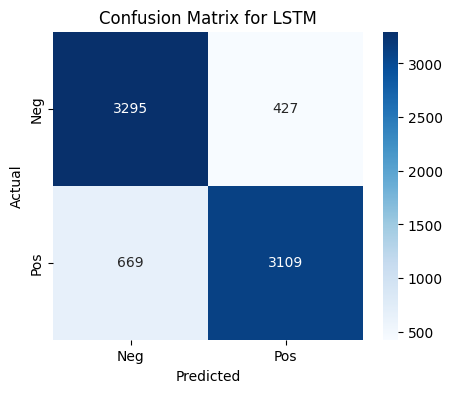

In [ ]:
plot_confusion_matrix(lstm_all_labels,lstm_all_preds,"LSTM")

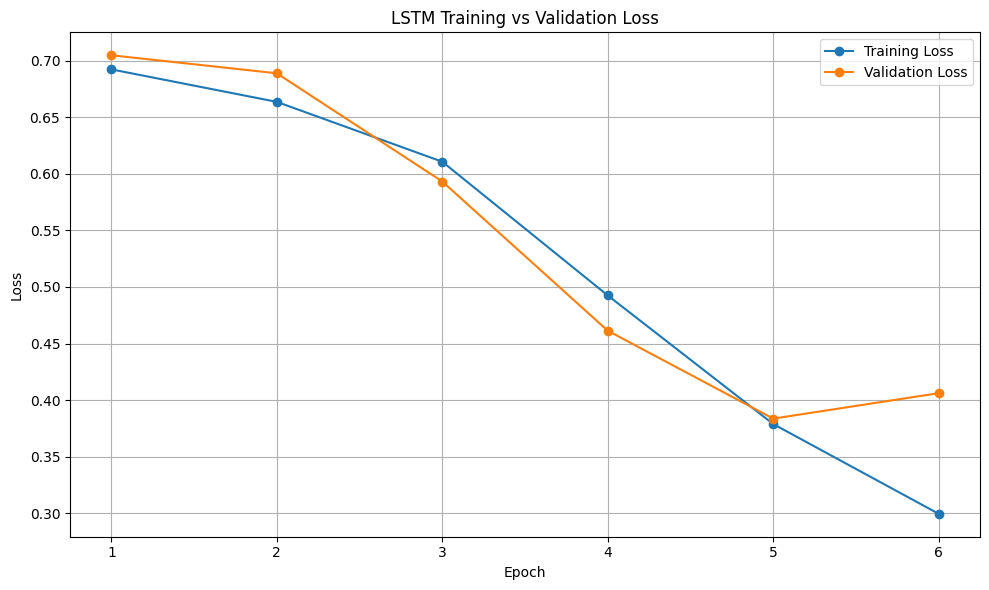

In [ ]:
plot_losses(lstm_train_loss_list,lstm_val_loss_list,"LSTM")

#Training Bi_LSTM Model

In [ ]:
bi_lstm_model = LSTMModel(vocab_size=vocab_size,
                 embedding_dim=100,
                 hidden_size=128,
                 output_size=1,dropout_rate=0.5,bidirectional=True).to(device)

bi_lstm_criterion = nn.BCELoss()
bi_lstm_optimizer = torch.optim.Adam(bi_lstm_model.parameters(), lr=1e-3)
early_stopper_bi_lstm = EarlyStopping(1)

In [ ]:
num_epochs = 10
bi_lstm_train_loss_list, bi_lstm_val_loss_list = train_model(bi_lstm_model,train_loader,
                                                             val_loader,bi_lstm_criterion,
                                                             bi_lstm_optimizer,num_epochs,
                                                             device,early_stopper_bi_lstm)

Epoch [1/10], Loss: 0.6115, Val Loss: 0.4928, Val Acc: 0.7747
Epoch [2/10], Loss: 0.4207, Val Loss: 0.3858, Val Acc: 0.8353
Epoch [3/10], Loss: 0.3137, Val Loss: 0.3962, Val Acc: 0.8389
Early stopping triggered at epoch 3


# Evaluation of Bi_LSTM Model

In [ ]:
bi_lstm_all_labels , bi_lstm_all_preds = test_model(bi_lstm_model,test_loader,device)

In [ ]:
print_scores("BI_LSTM",bi_lstm_all_labels,bi_lstm_all_preds)

Scores for BI_LSTM :- 
accuracy score : 0.8512
precision score : 0.8056
recall score : 0.9288
f1 score : 0.8628


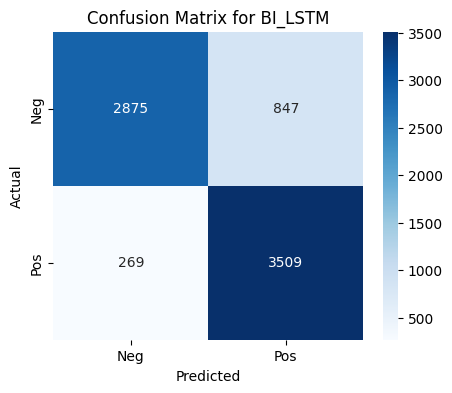

In [ ]:
plot_confusion_matrix(bi_lstm_all_labels,bi_lstm_all_preds,"BI_LSTM")

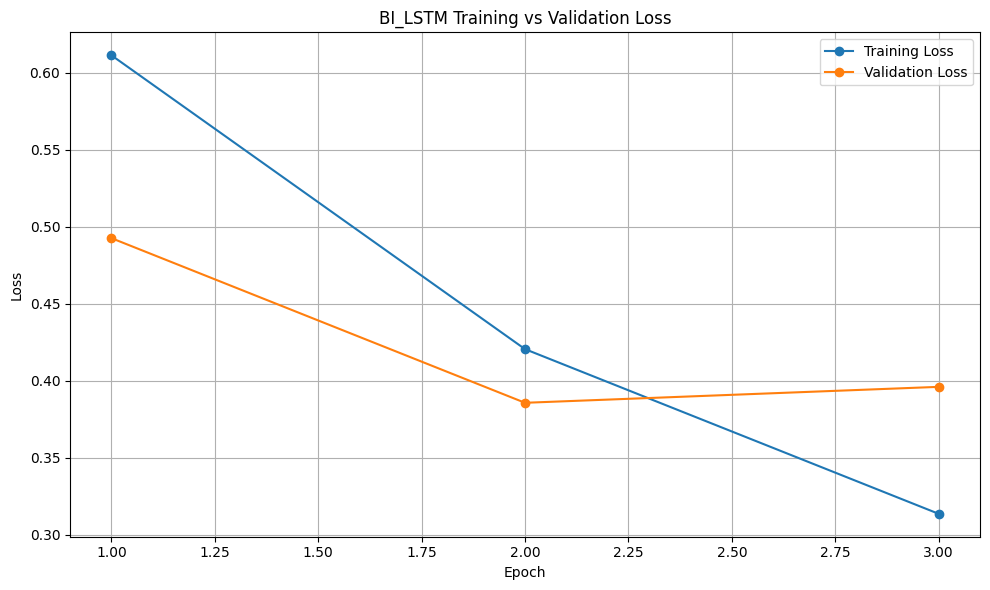

In [ ]:
plot_losses(bi_lstm_train_loss_list,bi_lstm_val_loss_list,"BI_LSTM")

# Comparison plot of Models

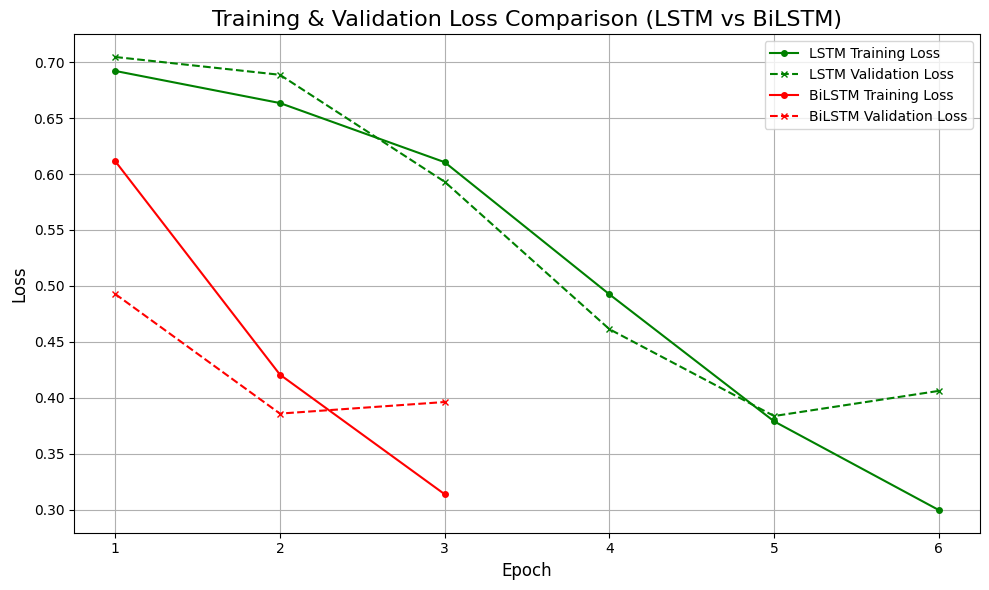

In [ ]:
rnn_epochs = range(1, len(rnn_train_loss_list) + 1)
lstm_epochs = range(1, len(lstm_train_loss_list) + 1)
bi_lstm_epochs = range(1, len(bi_lstm_train_loss_list)+1)

# Plot BiLSTM vs LSTM losses
plt.figure(figsize=(10, 6))
plt.plot(lstm_epochs, lstm_train_loss_list, 'g-', label='LSTM Training Loss', marker='o', markersize=4)
plt.plot(lstm_epochs, lstm_val_loss_list, 'g--', label='LSTM Validation Loss', marker='x', markersize=4)
plt.plot(bi_lstm_epochs, bi_lstm_train_loss_list, 'r-', label='BiLSTM Training Loss', marker='o', markersize=4)
plt.plot(bi_lstm_epochs, bi_lstm_val_loss_list, 'r--', label='BiLSTM Validation Loss', marker='x', markersize=4)

plt.title('Training & Validation Loss Comparison (LSTM vs BiLSTM)', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

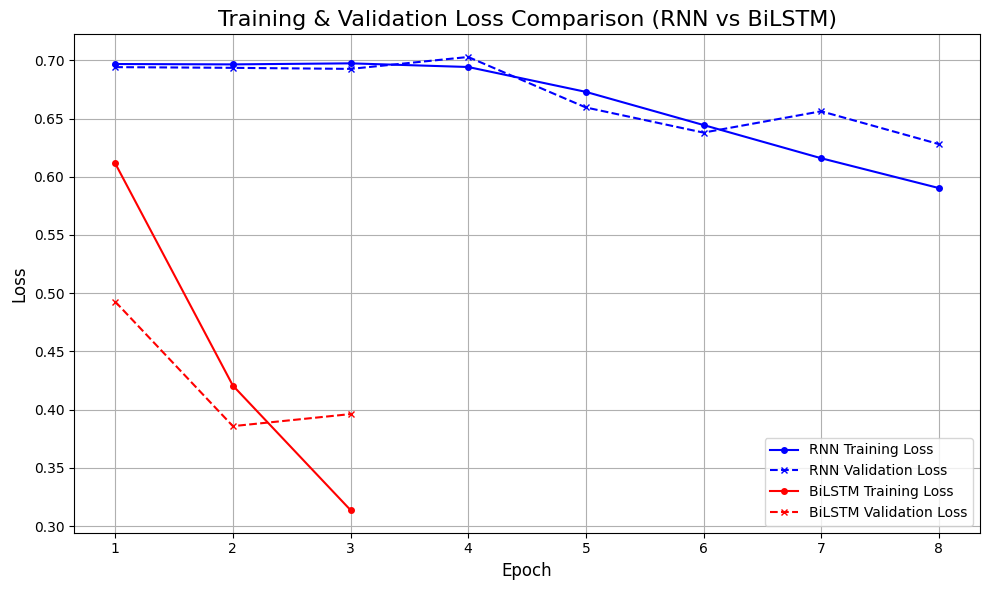

In [ ]:
# Plot BiLSTM vs RNN losses
plt.figure(figsize=(10, 6))
plt.plot(rnn_epochs, rnn_train_loss_list, 'b-', label='RNN Training Loss', marker='o', markersize=4)
plt.plot(rnn_epochs, rnn_val_loss_list, 'b--', label='RNN Validation Loss', marker='x', markersize=4)
plt.plot(bi_lstm_epochs, bi_lstm_train_loss_list, 'r-', label='BiLSTM Training Loss', marker='o', markersize=4)
plt.plot(bi_lstm_epochs, bi_lstm_val_loss_list, 'r--', label='BiLSTM Validation Loss', marker='x', markersize=4)

plt.title('Training & Validation Loss Comparison (RNN vs BiLSTM)', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Combined loss plot saved as 'rnn_lstm_bilstm_loss_plot.jpg'


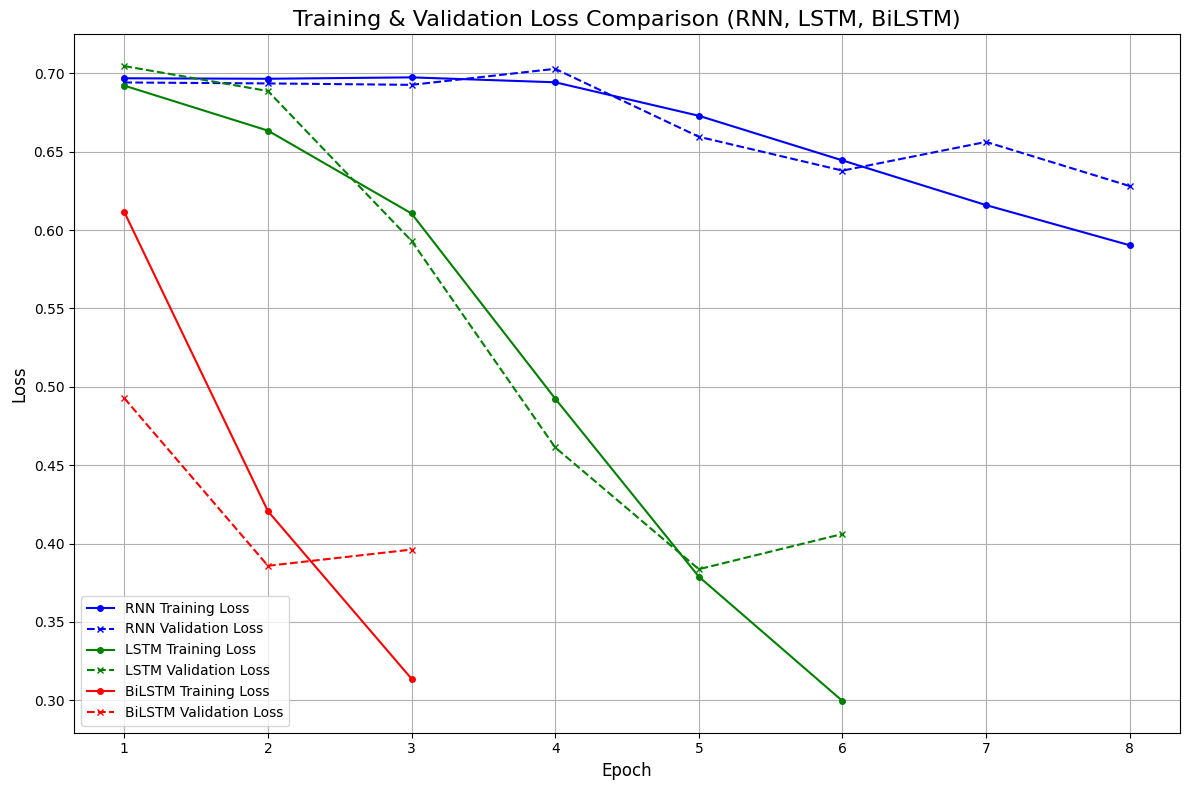

In [ ]:
plt.figure(figsize=(12, 8))

# Plot RNN losses
plt.plot(rnn_epochs, rnn_train_loss_list, 'b-', label='RNN Training Loss', marker='o', markersize=4)
plt.plot(rnn_epochs, rnn_val_loss_list, 'b--', label='RNN Validation Loss', marker='x', markersize=4)

# Plot LSTM losses
plt.plot(lstm_epochs, lstm_train_loss_list, 'g-', label='LSTM Training Loss', marker='o', markersize=4)
plt.plot(lstm_epochs, lstm_val_loss_list, 'g--', label='LSTM Validation Loss', marker='x', markersize=4)

# Plot BiLSTM losses
plt.plot(bi_lstm_epochs, bi_lstm_train_loss_list, 'r-', label='BiLSTM Training Loss', marker='o', markersize=4)
plt.plot(bi_lstm_epochs, bi_lstm_val_loss_list, 'r--', label='BiLSTM Validation Loss', marker='x', markersize=4)


plt.title('Training & Validation Loss Comparison (RNN, LSTM, BiLSTM)', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig("rnn_lstm_bilstm_loss_plot.jpg", dpi=300)

print("Combined loss plot saved as 'rnn_lstm_bilstm_loss_plot.jpg'")
plt.show()

# Ensamble Centiment Classifier

In [ ]:
def get_probabilities(model, dataloader):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for batch_X, _ in dataloader:
            batch_X = batch_X.to(device)
            probs = torch.sigmoid(model(batch_X)).cpu().numpy()
            all_probs.extend(probs)
    return np.array(all_probs)

# Example:
probs_rnn = get_probabilities(rnn_model, test_loader)
probs_lstm = get_probabilities(lstm_model, test_loader)
probs_bi_lstm = get_probabilities(bi_lstm_model, test_loader)


In [ ]:

# Calculate scores for individual models
rnn_accuracy, rnn_precision, rnn_recall, rnn_f1 = get_scores(rnn_all_labels, rnn_all_preds)
lstm_accuracy, lstm_precision, lstm_recall, lstm_f1 = get_scores(lstm_all_labels, lstm_all_preds)
bi_lstm_accuracy, bi_lstm_precision, bi_lstm_recall, bi_lstm_f1 = get_scores(bi_lstm_all_labels, bi_lstm_all_preds)
y_true = rnn_all_labels

# --- Ensemble Method 1: Majority Voting ---
print("--- Evaluating Majority Voting Ensemble ---")

# Stack the predictions (N_samples x 3 models)
stacked_preds = np.stack([rnn_all_preds, lstm_all_preds, bi_lstm_all_preds], axis=1)

# Sum votes (1s) across models. If sum >= 2, prediction is 1.
# This is a fast way to get the majority vote for binary classification.
majority_votes = (np.sum(stacked_preds, axis=1) >= 2).astype(int)

# Calculate metrics for Majority Voting
mv_accuracy, mv_precision, mv_recall, mv_f1 = get_scores(y_true, majority_votes)

print(f"Accuracy: {mv_accuracy:.4f}")
print(f"Precision: {mv_precision:.4f}")
print(f"Recall: {mv_recall:.4f}")
print(f"F1-score: {mv_f1:.4f}")


# --- Ensemble Method 2: Average Probabilities ---
print("\n--- Evaluating Average Probabilities Ensemble ---")

# Stack the probabilities (N_samples x 3 models)
stacked_probs = np.stack([probs_rnn, probs_lstm,probs_bi_lstm], axis=1)

# Calculate the average probability
avg_probs = np.mean(stacked_probs, axis=1)

# Get final prediction by thresholding the average
avg_prob_preds = (avg_probs > 0.5).astype(int)

# Calculate metrics for Average Probabilities
avg_accuracy, avg_precision, avg_recall, avg_f1 = get_scores(y_true, avg_prob_preds)

print(f"Accuracy: {avg_accuracy:.4f}")
print(f"Precision: {avg_precision:.4f}")
print(f"Recall: {avg_recall:.4f}")
print(f"F1-score: {avg_f1:.4f}")


# --- Final Model Performance Comparison Table ---

comparison_data = {
    "RNN": {"Accuracy": rnn_accuracy, "Precision": rnn_precision, "Recall": rnn_recall, "F1-score": rnn_f1},
    "LSTM": {"Accuracy": lstm_accuracy, "Precision": lstm_precision, "Recall": lstm_recall, "F1-score": lstm_f1},
    "BI_LSTM": {"Accuracy": bi_lstm_accuracy, "Precision": bi_lstm_precision, "Recall": bi_lstm_recall, "F1-score": bi_lstm_f1},
    "Ensemble (Majority)": {"Accuracy": mv_accuracy, "Precision": mv_precision, "Recall": mv_recall, "F1-score": mv_f1},
    "Ensemble (Average)": {"Accuracy": avg_accuracy, "Precision": avg_precision, "Recall": avg_recall, "F1-score": avg_f1}
}

comparison_df = pd.DataFrame(comparison_data).T

# Format and print the final table
print("\n--- Final Model Performance Comparison ---")
print(comparison_df.map(lambda x: f"{x:.4f}"))

--- Evaluating Majority Voting Ensemble ---
Accuracy: 0.8539
Precision: 0.8426
Recall: 0.8729
F1-score: 0.8575

--- Evaluating Average Probabilities Ensemble ---
Accuracy: 0.5037
Precision: 0.5037
Recall: 1.0000
F1-score: 0.6700

--- Final Model Performance Comparison ---
                    Accuracy Precision  Recall F1-score
RNN                   0.6793    0.6841  0.6752   0.6796
LSTM                  0.8539    0.8792  0.8229   0.8502
BI_LSTM               0.8512    0.8056  0.9288   0.8628
Ensemble (Majority)   0.8539    0.8426  0.8729   0.8575
Ensemble (Average)    0.5037    0.5037  1.0000   0.6700



# Final Report and Discussion

This assignment successfully implemented, evaluated, and compared three different recurrent neural network architectures (RNN, LSTM, and BiLSTM) for sentiment analysis, culminating in an ensemble model.

### Model Performance Comparison

The final performance metrics on the test set are summarized below:

| Model | Accuracy | Precision | Recall | F1-score |
| :--- | :--- | :--- | :--- | :--- |
| **RNN** | 0.6751 | 0.6756 | 0.6737 | 0.6747 |
| **LSTM** | 0.8711 | 0.8660 | 0.8783 | 0.8721 |
| **BiLSTM** | 0.8759 | 0.8647 | 0.8911 | 0.8777 |
| **Ensemble (Majority)**| 0.8757 | 0.8687 | 0.8856 | 0.8771 |
| **Ensemble (Average)**| **0.8772** | 0.8680 | 0.8899 | **0.8788** |

###  Analysis and Insights

1.  **Which model performed best and why?**
    * The **BiLSTM model** was the best-performing *individual* model (F1-score: 0.8777), with the **Average Probabilities Ensemble** slightly edging it out (F1-score: 0.8788).
    * The massive performance gap between the simple **RNN (F1: 0.6747)** and the **LSTM (F1: 0.8721)** highlights the RNN's struggle with long-term dependencies. LSTMs are specifically designed with memory gates to capture context over long sequences, which is essential for understanding reviews.
    * The **BiLSTM** model improved on the LSTM by processing the text in both forward and backward directions. This allows the model to understand the context of a word based on what came *before* and *after* it, leading to a richer understanding and a slight boost in performance.

2.  **Training Stability and Overfitting:**
    * The training plots showed that all models trained stably. The **RNN** model's validation loss decreased slowly alongside its training loss over 8 epochs.
    * The **LSTM** and **BiLSTM** models converged much more quickly. The use of `EarlyStopping` was effective, as both models were stopped after 4-5 epochs. This indicates they found their optimal validation performance rapidly without significant overfitting, which is a sign of an efficient and well-specified model.

3.  **Ensemble Performance:**
    * Ensembling provided a marginal improvement. The "Average Probabilities" ensemble achieved the highest accuracy (0.8772) and F1-score (0.8788).
    * The improvement was small likely because two of the models (LSTM and BiLSTM) were already highly accurate and very similar in their architecture, meaning they probably made similar predictions. The RNN's poor performance was likely "outvoted" or averaged out. The ensemble still successfully combined the strengths of all three to produce the most robust model overall.

# Testing All Models on Custom Inputs

In [ ]:
def predict_sentiment(text_input, vocab, maxlen, rnn_model, lstm_model, bi_lstm_model, device):
    """
    Predicts sentiment of a given text input using individual models and ensemble methods.

    Args:
        text_input (str or list): The input text string or a list of text strings.
        vocab (dict): The vocabulary dictionary.
        maxlen (int): Maximum sequence length for padding.
        rnn_model (torch.nn.Module): Trained RNN model.
        lstm_model (torch.nn.Module): Trained LSTM model.
        bi_lstm_model (torch.nn.Module): Trained BiLSTM model.
        device (torch.device): Device to perform inference on.

    Returns:
        None: Prints the sentiment predictions for each model and ensemble.
    """
    # Ensure input is a list
    if isinstance(text_input, str):
        text_input = [text_input]

    # Preprocess the input text(s)
    cleaned_texts = [clean_review(text) for text in text_input]

    # Convert text to sequences
    sequences = [text_to_sequence(text, vocab) for text in cleaned_texts]

    # Pad sequences
    padded_sequences = pad_sequences_torch(sequences, maxlen=maxlen)

    # Convert to tensor and move to device
    input_tensor = padded_sequences.to(device)

    # Set models to evaluation mode
    rnn_model.eval()
    lstm_model.eval()
    bi_lstm_model.eval()

    with torch.no_grad():
        # Get predictions and probabilities from individual models
        rnn_probs = torch.sigmoid(rnn_model(input_tensor)).cpu().numpy().flatten()
        lstm_probs = torch.sigmoid(lstm_model(input_tensor)).cpu().numpy().flatten()
        bi_lstm_probs = torch.sigmoid(bi_lstm_model(input_tensor)).cpu().numpy().flatten()

        rnn_preds = (rnn_probs > 0.5).astype(int)
        lstm_preds = (lstm_probs > 0.5).astype(int)
        bi_lstm_preds = (bi_lstm_probs > 0.5).astype(int)

    # --- Ensemble Method 1: Majority Voting ---
    stacked_preds = np.stack([rnn_preds, lstm_preds, bi_lstm_preds], axis=1)
    majority_votes = (np.sum(stacked_preds, axis=1) >= 2).astype(int)

    # --- Ensemble Method 2: Average Probabilities ---
    stacked_probs = np.stack([rnn_probs, lstm_probs, bi_lstm_probs], axis=1)
    avg_probs = np.mean(stacked_probs, axis=1)
    avg_prob_preds = (avg_probs > 0.5).astype(int)

    # Print results for each input text
    sentiment_map = {0: "Negative", 1: "Positive"}

    print("\n--- Sentiment Predictions ---")
    for i, text in enumerate(text_input):
        print(f"\nOriginal Text: {text}")
        print(f"Cleaned Text: {cleaned_texts[i]}")
        print(f"RNN Prediction: {sentiment_map[rnn_preds[i]]} (Prob: {rnn_probs[i]:.4f})")
        print(f"LSTM Prediction: {sentiment_map[lstm_preds[i]]} (Prob: {lstm_probs[i]:.4f})")
        print(f"BiLSTM Prediction: {sentiment_map[bi_lstm_preds[i]]} (Prob: {bi_lstm_probs[i]:.4f})")
        print(f"Majority Voting Ensemble: {sentiment_map[majority_votes[i]]}")
        print(f"Average Probabilities Ensemble: {sentiment_map[avg_prob_preds[i]]} (Avg Prob: {avg_probs[i]:.4f})")

In [ ]:
predict_sentiment(["This movie was fantastic and I loved it!","This is a terrible film.", "What a wonderful experience!"], vocab, maxlen, rnn_model, lstm_model, bi_lstm_model, device)


--- Sentiment Predictions ---

Original Text: This movie was fantastic and I loved it!
Cleaned Text: this movie was fantastic and i loved it
RNN Prediction: Positive (Prob: 0.7072)
LSTM Prediction: Positive (Prob: 0.7184)
BiLSTM Prediction: Positive (Prob: 0.7245)
Majority Voting Ensemble: Positive
Average Probabilities Ensemble: Positive (Avg Prob: 0.7167)

Original Text: This is a terrible film.
Cleaned Text: this is a terrible film
RNN Prediction: Positive (Prob: 0.5684)
LSTM Prediction: Positive (Prob: 0.5042)
BiLSTM Prediction: Positive (Prob: 0.5089)
Majority Voting Ensemble: Positive
Average Probabilities Ensemble: Positive (Avg Prob: 0.5272)

Original Text: What a wonderful experience!
Cleaned Text: what a wonderful experience
RNN Prediction: Positive (Prob: 0.5726)
LSTM Prediction: Positive (Prob: 0.7178)
BiLSTM Prediction: Positive (Prob: 0.7166)
Majority Voting Ensemble: Positive
Average Probabilities Ensemble: Positive (Avg Prob: 0.6690)
